In [ ]:
import pandas as pd
import numpy as np

# dataset
df = pd.read_csv("../intermedio_sin_outliers.csv")
df.head()

,Año,Puertas,Con cámara de retroceso,Kilómetros,Precio_usd,Marca_Alfa Romeo,Marca_Audi,Marca_BAIC,Marca_BMW,Marca_Chery,...,Combustible_Mild Hybrid,Combustible_Nafta,Combustible_Nafta/GNC,Transmision_Automática,Transmision_Automática secuencial,Transmision_Manual,Transmision_Semiautomática,Vendedor_concesionaria,Vendedor_particular,Vendedor_tienda
0,2020.0,5.0,0,64000,17596.566524,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
1,2024.0,5.0,1,0,48068.583691,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2,2019.0,5.0,0,65300,28300.000000,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
3,2017.0,5.0,0,76898,17244.635193,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,2021.0,5.0,1,109000,23000.000000,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


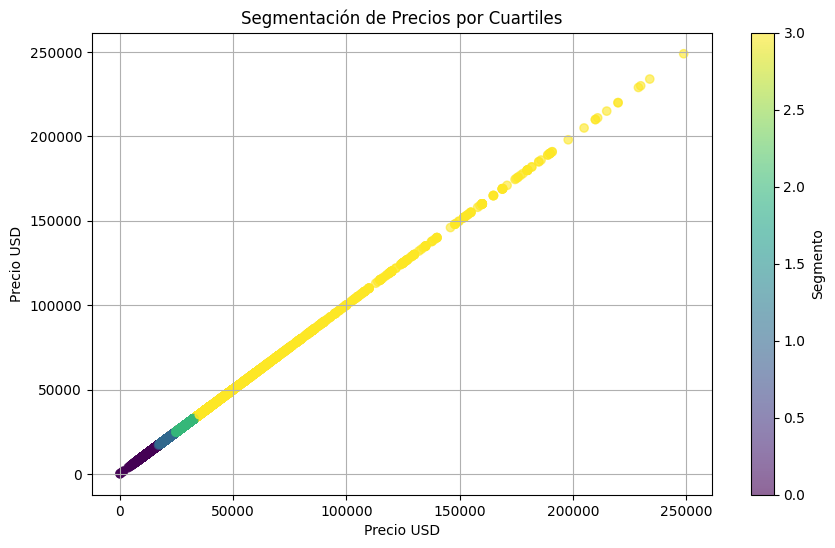

Cantidad por segmento:
segmento
0    4392
1    4277
2    4340
3    4329
Name: count, dtype: int64


In [2]:
import pandas as pd

# Crear columna de cuartil del precio normalizado
df['segmento'] = pd.qcut(df['Precio_usd'], q=4, labels=[0, 1, 2, 3])
df['segmento'] = df['segmento'].astype(int)

# grafico los precios en plano coloreados por segmentos 
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df['Precio_usd'], df['Precio_usd'], c=df['segmento'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Segmento')
plt.xlabel('Precio USD')
plt.ylabel('Precio USD')
plt.title('Segmentación de Precios por Cuartiles')
plt.grid(True)
plt.show()

# Cantidad por cuartil
cantidad_por_segmento = df['segmento'].value_counts().sort_index()
print("Cantidad por segmento:")
print(cantidad_por_segmento)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier

# 1. Separar X e y
X = df.drop(columns=['Precio_usd', 'segmento'])
y = df['segmento']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

# 2. Crear pipeline con escalador y MLP
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=500, random_state=42))
])

# 3. Definir espacio de búsqueda sobre el paso 'mlp'
param_grid = {
    'mlp__hidden_layer_sizes': [(32,), (64,), (128,), (64, 32), (128, 64)],
    'mlp__activation':           ['relu', 'tanh'],
    'mlp__alpha':                [0.0001, 0.001, 0.01],
    'mlp__learning_rate':        ['constant', 'adaptive']
}

# 4. GridSearchCV sobre pipeline
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# 5. Entrenar y evaluar
grid.fit(X_train, y_train)
print("✅ Mejores hiperparámetros:", grid.best_params_)
print("🎯 Accuracy en test:", grid.score(X_test, y_test))


Fitting 3 folds for each of 60 candidates, totalling 180 fits


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.wa

✅ Mejores hiperparámetros: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (128,), 'mlp__learning_rate': 'constant'}
🎯 Accuracy en test: 0.7727797001153403


In [4]:
# Usar el mejor modelo MLP ya entrenado
mlp_final = grid.best_estimator_

# Predecir el segmento para todo el dataset (sin usar precio)
X_full = df.drop(columns=['Precio_usd', 'segmento'])
df['segmento_predicho'] = mlp_final.predict(X_full)

df.head()

,Año,Puertas,Con cámara de retroceso,Kilómetros,Precio_usd,Marca_Alfa Romeo,Marca_Audi,Marca_BAIC,Marca_BMW,Marca_Chery,...,Combustible_Nafta/GNC,Transmision_Automática,Transmision_Automática secuencial,Transmision_Manual,Transmision_Semiautomática,Vendedor_concesionaria,Vendedor_particular,Vendedor_tienda,segmento,segmento_predicho
0,2020.0,5.0,0,64000,17596.566524,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,2024.0,5.0,1,0,48068.583691,0,0,0,0,0,...,0,0,1,0,0,0,0,1,3,3
2,2019.0,5.0,0,65300,28300.000000,0,0,0,0,0,...,0,1,0,0,0,0,1,0,2,2
3,2017.0,5.0,0,76898,17244.635193,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
4,2021.0,5.0,1,109000,23000.000000,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,1


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Guardar modelos y métricas
modelos_rf = {}
resultados = []

# Espacio de búsqueda ampliado
param_grid = {
    'n_estimators':     [100, 200, 500],
    'max_depth':        [5, 10, 15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf':  [1, 2],
    'max_features':     ['sqrt', 'log2', 0.5, 0.75]
}

for segmento in sorted(df['segmento_predicho'].unique()):
    print(f"\n🔍 Optimizando segmento {segmento}...")
    df_seg = df[df['segmento_predicho'] == segmento].copy()
    
    # Features y target
    X = df_seg.drop(columns=['Precio_usd','segmento','segmento_predicho'])
    y = df_seg['Precio_usd']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=42
    )
    
    # Transformación logarítmica del target
    y_train_log = np.log1p(y_train)
    
    # Configurar GridSearchCV optimizando MAE
    rf = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(
        rf,
        param_grid,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train_log)
    
    # Mejor modelo
    best_rf = grid.best_estimator_
    modelos_rf[segmento] = best_rf
    
    # Predicción: del espacio log a escala original
    y_pred_log = best_rf.predict(X_test)
    y_pred     = np.expm1(y_pred_log)
    
    # Métricas en la escala original
    resultados.append({
        'segmento':      segmento,
        'MAE':           mean_absolute_error(y_test, y_pred),
        'RMSE':          np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2':            r2_score(y_test, y_pred),
        'mejores_params': grid.best_params_
    })

# Mostrar resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)



🔍 Optimizando segmento 0...

🔍 Optimizando segmento 1...

🔍 Optimizando segmento 2...

🔍 Optimizando segmento 3...
   segmento          MAE          RMSE        R2  \
0         0  1267.919517   1983.070837  0.600912   
1         1  1479.102862   2222.091343  0.495451   
2         2  2692.762985   3979.031263  0.394970   
3         3  5709.530091  11332.777756  0.806773   

                                      mejores_params  
0  {'max_depth': 10, 'max_features': 0.5, 'min_sa...  
1  {'max_depth': None, 'max_features': 0.5, 'min_...  
2  {'max_depth': None, 'max_features': 0.5, 'min_...  
3  {'max_depth': None, 'max_features': 0.5, 'min_...  


In [6]:
# Partimos de tu df_resultados que tiene la columna 'mejores_params' con dicts
import pandas as pd

# 1. Convertir la columna de dicts en un DataFrame
params_df = pd.json_normalize(df_resultados['mejores_params'])

# 2. Concatenar ese DataFrame al original (y opcionalmente eliminar la columna de dicts)
df_final = pd.concat(
    [ df_resultados.drop(columns=['mejores_params']), 
      params_df ],
    axis=1
)

print(df_final)


   segmento          MAE          RMSE        R2  max_depth  max_features  \
0         0  1267.919517   1983.070837  0.600912       10.0           0.5   
1         1  1479.102862   2222.091343  0.495451        NaN           0.5   
2         2  2692.762985   3979.031263  0.394970        NaN           0.5   
3         3  5709.530091  11332.777756  0.806773        NaN           0.5   

   min_samples_leaf  min_samples_split  n_estimators  
0                 2                  5           500  
1                 1                  2           500  
2                 2                  2           200  
3                 1                  2           100  


/var/folders/h8/075vvj7s65sgq5xnd_m0zfkc0000gn/T/ipykernel_91227/1916857565.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='segmento', y='MAE', data=df_final, palette='Blues_r')
/var/folders/h8/075vvj7s65sgq5xnd_m0zfkc0000gn/T/ipykernel_91227/1916857565.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='segmento', y='RMSE', data=df_final, palette='Greens_r')
/var/folders/h8/075vvj7s65sgq5xnd_m0zfkc0000gn/T/ipykernel_91227/1916857565.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='segmento', y='R2', data=df_final, palette

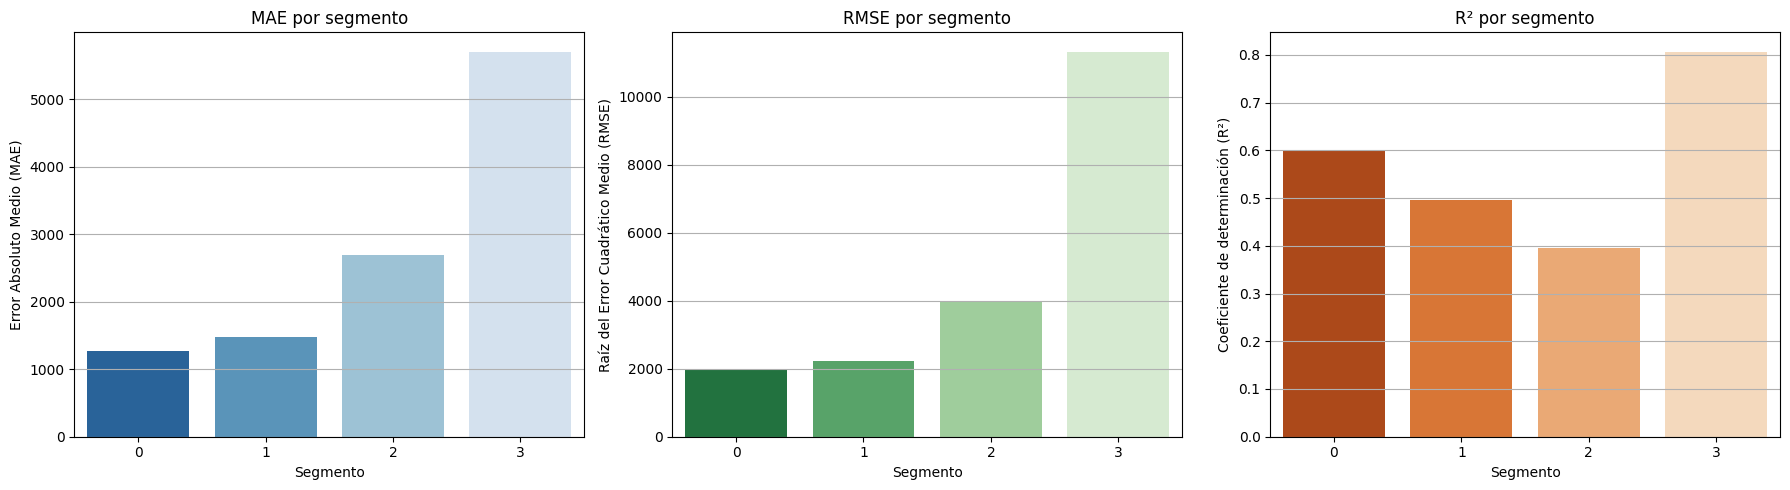

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suponemos que el DataFrame es df_final y tiene las columnas: segmento, MAE, RMSE, R2

# Configuración general
plt.figure(figsize=(18, 5))

# ----------- MAE -----------
plt.subplot(1, 3, 1)
sns.barplot(x='segmento', y='MAE', data=df_final, palette='Blues_r')
plt.title('MAE por segmento')
plt.xlabel('Segmento')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.grid(axis='y')

# ----------- RMSE -----------
plt.subplot(1, 3, 2)
sns.barplot(x='segmento', y='RMSE', data=df_final, palette='Greens_r')
plt.title('RMSE por segmento')
plt.xlabel('Segmento')
plt.ylabel('Raíz del Error Cuadrático Medio (RMSE)')
plt.grid(axis='y')

# ----------- R² -----------
plt.subplot(1, 3, 3)
sns.barplot(x='segmento', y='R2', data=df_final, palette='Oranges_r')
plt.title('R² por segmento')
plt.xlabel('Segmento')
plt.ylabel('Coeficiente de determinación (R²)')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
df_test = pd.read_csv("../pf_dataset_test_final.csv")

In [17]:
X_train.columns.tolist()
df_test.columns.tolist()
df_test = df_test.drop(columns=['Combustible_Diésel.1'], errors='ignore')


In [18]:
#prediccion de segmento, el test no tinee precio
df_test['segmento_predicho'] = mlp_final.predict(df_test)
# Predecir el precio usando los modelos de Random Forest
def predecir_precio(row):
    segmento = row['segmento_predicho']
    modelo_rf = modelos_rf[segmento]
    X_row = row.drop(['segmento_predicho']).values.reshape(1, -1)
    pred_log = modelo_rf.predict(X_row)
    return np.expm1(pred_log)
# Aplicar la función de predicción al DataFrame de test
df_test['Precio_usd_predicho'] = df_test.apply(predecir_precio, axis=1)
# Guardar el DataFrame con las predicciones
df_test.to_csv("predicciones_test_final.csv", index=False)

/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have